In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_rmse_perc'
metric_filter_2 = 'val_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.5, 0.25, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

#### Results

In [ ]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 330/330 [00:26<00:00, 12.63it/s]


In [ ]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.60766476,
 'train_acc': 0.518666684627533,
 'val_acc': 0.48533332347869873,
 'epoch': 80,
 'model_class': 'fnn',
 'path_name': '4_[10_15]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_80',
 'train_rmse': 0.8679477710861024,
 'val_rmse': 0.9266426855410163,
 'test_rmse': 0.9106774035482232,
 'train_rmse_perc': 0.20963843,
 'val_rmse_perc': 0.22350323,
 'test_rmse_perc': 0.21673168,
 'train_mcc': 0.377102392635433,
 'val_mcc': 0.34588200169236233,
 'test_mcc': 0.4015125666653856,
 'test_acc': 0.527999997138977}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6711254,
 'train_acc': 0.515999972820282,
 'val_acc': 0.47999998927116394,
 'epoch': 70,
 'model_class': 'fnn',
 'path_name': '4_[10_15_20]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_70',
 'train_rmse': 0.8839306156782518,
 'val_rmse': 0.920869154657707,
 'test_rmse': 0.9121403400793103,
 'train_rmse_perc': 0.23364072,
 'val_rmse_perc': 0.24177992,
 'test_rmse_perc': 0.24418716,
 'train_mcc': 0.38651942077101703,
 'val_mcc': 0.3526735217499787,
 'test_mcc': 0.409551458844776,
 'test_acc': 0.5253333449363708}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6455171,
 'train_acc': 0.4946666657924652,
 'val_acc': 0.4959999918937683,
 'epoch': 70,
 'model_class': 'fnn',
 'path_name': '4_[5_10_15]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_70',
 'train_rmse': 0.848528137423857,
 'val_rmse': 0.8532291603080616,
 'test_rmse': 0.8532291603080616,
 'train_rmse_perc': 0.21382564,
 'val_rmse_perc': 0.22014575,
 'test_rmse_perc': 0.21691181,
 'train_mcc': 0.3641800396262361,
 'val_mcc': 0.39092342905437,
 'test_mcc': 0.3936933818614978,
 'test_acc': 0.5120000243186951}

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 330/330 [00:00<00:00, 23635.13it/s]


In [ ]:
cm = all[sort_idx[0]]['test_cm'][0]

In [ ]:
(cm.labels==0).sum()

tensor(230)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

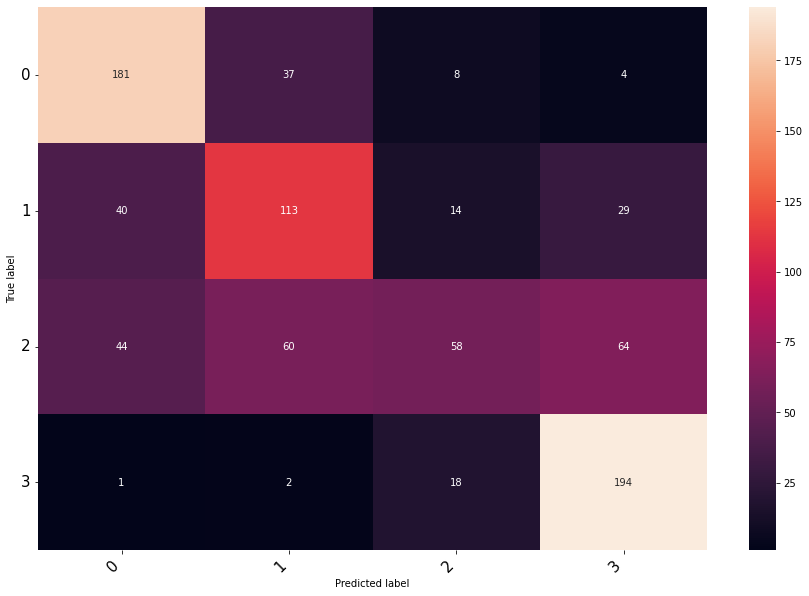

In [ ]:
cm.visualize()

In [ ]:
cm.class_accuracy

tensor([0.7870, 0.5765, 0.2566, 0.9023])

In [ ]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.17763509, 0.2611884, 0.27546555, 0.12878902]

In [ ]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.11359891, 0.18939438, 0.22494318, 0.09887825]

### GCN

In [ ]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [15:03<00:00, 12.55s/it]


#### Results

In [ ]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 792/792 [01:17<00:00, 10.21it/s]


In [ ]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.7441219,
 'train_acc': 0.42533332109451294,
 'val_acc': 0.40799999237060547,
 'epoch': 99,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_None_0.2_0.1_adamw_max_val_mcc_True_mse_True_0',
 'train_rmse': 0.920869154657707,
 'val_rmse': 0.8839306156782518,
 'test_rmse': 0.920869154657707,
 'train_rmse_perc': 0.23325546,
 'val_rmse_perc': 0.22078858,
 'test_rmse_perc': 0.23708498,
 'train_mcc': 0.2903318448923539,
 'val_mcc': 0.29377765843485065,
 'test_mcc': 0.3045443958942615,
 'test_acc': 0.4399999976158142}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.89451903,
 'train_acc': 0.4386666715145111,
 'val_acc': 0.41333332657814026,
 'epoch': 30,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_None_0.0_0.1_adamw_max_val_mcc_True_mse_True_0.2_30',
 'train_rmse': 0.8816650913659525,
 'val_rmse': 0.8959166627910582,
 'test_rmse': 0.9237604307034013,
 'train_rmse_perc': 0.21874504,
 'val_rmse_perc': 0.21898448,
 'test_rmse_perc': 0.21924268,
 'train_mcc': 0.34508951019723894,
 'val_mcc': 0.3416891646618209,
 'test_mcc': 0.32354538346094747,
 'test_acc': 0.4266666769981384}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.82210374,
 'train_acc': 0.4333333373069763,
 'val_acc': 0.42933332920074463,
 'epoch': 30,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_gn_0.2_0.1_adamw_max_val_mcc_True_mse_True_0.2_30',
 'train_rmse': 0.8839306156782518,
 'val_rmse': 0.886942313043338,
 'test_rmse': 0.9280804562823922,
 'train_rmse_perc': 0.22246619,
 'val_rmse_perc': 0.2176407,
 'test_rmse_perc': 0.2231113,
 'train_mcc': 0.33376042677293066,
 'val_mcc': 0.35995862028755415,
 'test_mcc': 0.3034604899800657,
 'test_acc': 0.41600000858306885}

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 792/792 [00:00<00:00, 29411.82it/s]


### GraphSAGE

In [7]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 144/144 [2:24:38<00:00, 60.27s/it] 


#### Results

In [9]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [05:28<00:00,  3.62it/s]


True

In [10]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.03548379,
 'train_acc': 0.9440000057220459,
 'val_acc': 0.8533333539962769,
 'epoch': 85,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0',
 'train_rmse': 0.23664319132398465,
 'val_rmse': 0.39327683210007003,
 'test_rmse': 0.4788875998951459,
 'train_rmse_perc': 0.083603136,
 'val_rmse_perc': 0.09266845,
 'test_rmse_perc': 0.11741615,
 'train_mcc': 0.9271670528371249,
 'val_mcc': 0.8100436775296593,
 'test_mcc': 0.7883552223799615,
 'test_acc': 0.8373333215713501}

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.03548379,
 'train_acc': 0.9440000057220459,
 'val_acc': 0.8533333539962769,
 'epoch': 85,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0',
 'train_rmse': 0.23664319132398465,
 'val_rmse': 0.39327683210007003,
 'test_rmse': 0.4788875998951459,
 'train_rmse_perc': 0.083603136,
 'val_rmse_perc': 0.09266845,
 'test_rmse_perc': 0.11741615,
 'train_mcc': 0.9271670528371249,
 'val_mcc': 0.8100436775296593,
 'test_mcc': 0.7883552223799615,
 'test_acc': 0.8373333215713501}

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.03548379,
 'train_acc': 0.9440000057220459,
 'val_acc': 0.8533333539962769,
 'epoch': 85,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0',
 'train_rmse': 0.23664319132398465,
 'val_rmse': 0.39327683210007003,
 'test_rmse': 0.4788875998951459,
 'train_rmse_perc': 0.083603136,
 'val_rmse_perc': 0.09266845,
 'test_rmse_perc': 0.11741615,
 'train_mcc': 0.9271670528371249,
 'val_mcc': 0.8100436775296593,
 'test_mcc': 0.7883552223799615,
 'test_acc': 0.8373333215713501}

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 30542.73it/s]


#### cm

In [14]:
cm = all[sort_idx[0]]['test_cm'][0]

In [15]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

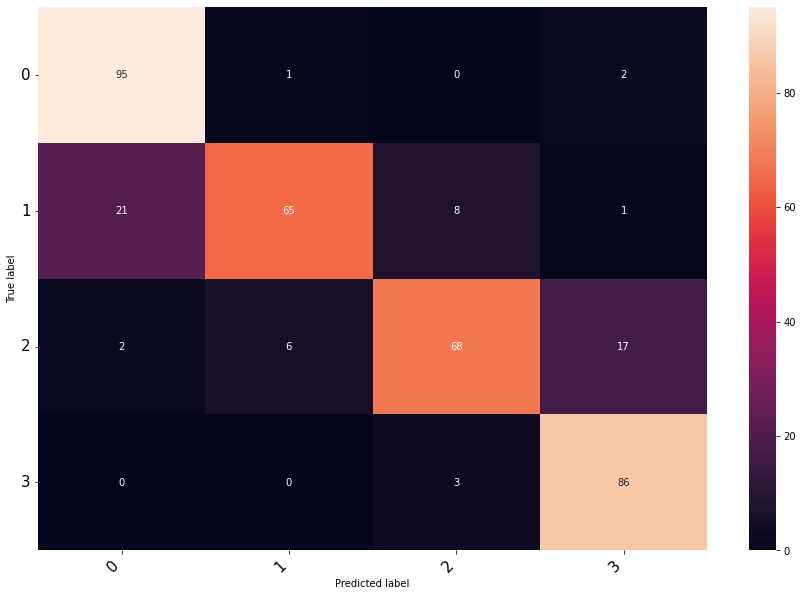

In [16]:
cm.visualize()

In [17]:
cm.class_accuracy

tensor([0.9694, 0.6842, 0.7312, 0.9663])

In [18]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.1330684, 0.13963062, 0.09927813, 0.08649498]

In [19]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.091591254, 0.09434434, 0.0676053, 0.07155439]

#### GraphSAGE Base_n

In [20]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [21]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            base_n=True,
        )

100%|██████████| 144/144 [2:22:01<00:00, 59.18s/it] 


##### Results

In [22]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [04:27<00:00,  4.43it/s]


True

In [23]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.1665002,
 'train_acc': 0.7360000014305115,
 'val_acc': 0.6746666431427002,
 'epoch': 40,
 'model_class': 'sage',
 'path_name': '4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_40',
 'train_rmse': 0.5403702434442518,
 'val_rmse': 0.6408327915038888,
 'test_rmse': 0.6239658110292048,
 'train_rmse_perc': 0.11866944,
 'val_rmse_perc': 0.13427174,
 'test_rmse_perc': 0.124593645,
 'train_mcc': 0.653793595093866,
 'val_mcc': 0.5760529939787639,
 'test_mcc': 0.6061775912188782,
 'test_acc': 0.6959999799728394}

In [24]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.1665002,
 'train_acc': 0.7360000014305115,
 'val_acc': 0.6746666431427002,
 'epoch': 40,
 'model_class': 'sage',
 'path_name': '4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_40',
 'train_rmse': 0.5403702434442518,
 'val_rmse': 0.6408327915038888,
 'test_rmse': 0.6239658110292048,
 'train_rmse_perc': 0.11866944,
 'val_rmse_perc': 0.13427174,
 'test_rmse_perc': 0.124593645,
 'train_mcc': 0.653793595093866,
 'val_mcc': 0.5760529939787639,
 'test_mcc': 0.6061775912188782,
 'test_acc': 0.6959999799728394}

In [25]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.07471406,
 'train_acc': 0.690666675567627,
 'val_acc': 0.6959999799728394,
 'epoch': 50,
 'model_class': 'sage',
 'path_name': '4_[25_25_25]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_50',
 'train_rmse': 0.5561774297230456,
 'val_rmse': 0.565685424949238,
 'test_rmse': 0.6175219294351686,
 'train_rmse_perc': 0.11661998,
 'val_rmse_perc': 0.115901634,
 'test_rmse_perc': 0.12932338,
 'train_mcc': 0.6152784040538454,
 'val_mcc': 0.6199061800906623,
 'test_mcc': 0.54632067484645,
 'test_acc': 0.6426666378974915}

In [26]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 28360.86it/s]


##### cm

In [27]:
cm = all[sort_idx[0]]['test_cm'][0]

In [28]:
(cm.labels==0).sum()

tensor(98)

In [29]:
cm.pseudo_perc.max()

tensor(0.9994)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

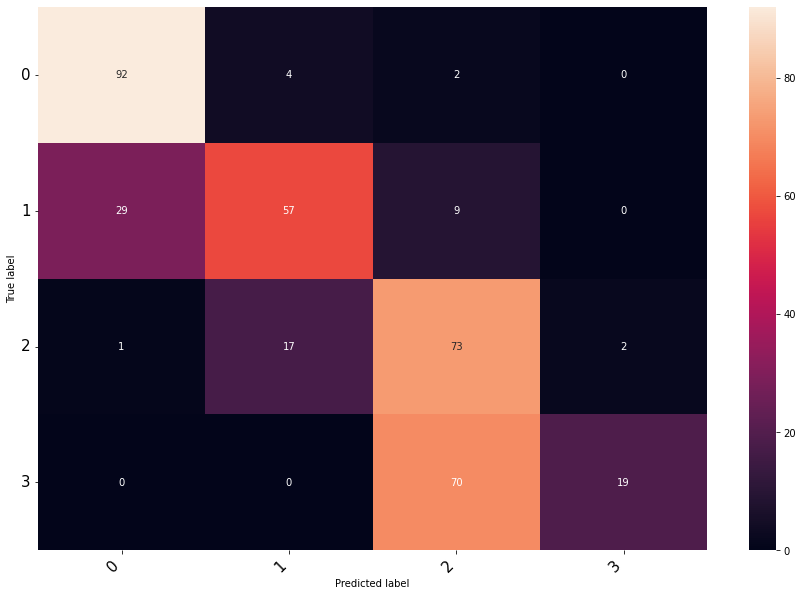

In [30]:
cm.visualize()

In [31]:
cm.class_accuracy

tensor([0.9388, 0.6000, 0.7849, 0.2135])

In [32]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.107140265, 0.12833679, 0.10675126, 0.16834493]

In [33]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.07921901, 0.10069423, 0.08376772, 0.15583834]

### GAT

In [34]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [35]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 288/288 [28:50<00:00,  6.01s/it]


#### Results

In [36]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 3168/3168 [02:17<00:00, 22.99it/s]


In [37]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.727152,
 'train_acc': 0.6506666541099548,
 'val_acc': 0.6666666865348816,
 'epoch': 92,
 'model_class': 'gat',
 'path_name': '4_[25]_1_[4_4]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2',
 'train_rmse': 0.7220341635499897,
 'val_rmse': 0.7155417527999327,
 'test_rmse': 0.7192588778272627,
 'train_rmse_perc': 0.16651598,
 'val_rmse_perc': 0.16130958,
 'test_rmse_perc': 0.16222051,
 'train_mcc': 0.5342425173277258,
 'val_mcc': 0.5559252873683139,
 'test_mcc': 0.48215085899881266,
 'test_acc': 0.6106666922569

In [38]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.727152,
 'train_acc': 0.6506666541099548,
 'val_acc': 0.6666666865348816,
 'epoch': 92,
 'model_class': 'gat',
 'path_name': '4_[25]_1_[4_4]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2',
 'train_rmse': 0.7220341635499897,
 'val_rmse': 0.7155417527999327,
 'test_rmse': 0.7192588778272627,
 'train_rmse_perc': 0.16651598,
 'val_rmse_perc': 0.16130958,
 'test_rmse_perc': 0.16222051,
 'train_mcc': 0.5342425173277258,
 'val_mcc': 0.5559252873683139,
 'test_mcc': 0.48215085899881266,
 'test_acc': 0.6106666922569

In [39]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.727152,
 'train_acc': 0.6506666541099548,
 'val_acc': 0.6666666865348816,
 'epoch': 92,
 'model_class': 'gat',
 'path_name': '4_[25]_1_[4_4]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2',
 'train_rmse': 0.7220341635499897,
 'val_rmse': 0.7155417527999327,
 'test_rmse': 0.7192588778272627,
 'train_rmse_perc': 0.16651598,
 'val_rmse_perc': 0.16130958,
 'test_rmse_perc': 0.16222051,
 'train_mcc': 0.5342425173277258,
 'val_mcc': 0.5559252873683139,
 'test_mcc': 0.48215085899881266,
 'test_acc': 0.6106666922569

In [40]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3168/3168 [00:00<00:00, 28616.74it/s]
